# Homework 11 - Transfer Learning (Domain Adversarial Training)

> Author: Arvin Liu (r09922071@ntu.edu.tw)

If there are any questions, please contact ntu-ml-2021spring-ta@googlegroups.com

# Readme

In homework 11, you will need to implement Domain Adversarial Training in Transfer Learning. As shown in the bottom left part of the figure.

<img src="https://i.imgur.com/iMVIxCH.png" width="500px">

> 

## Scenario and Why Domain Adversarial Training
Now we have labeled source data and unlabeled target data, where source data might be relavent to the target data. We now want to train a model with source data only and test it on target data.

What problem might occur if we do so? After we have learned Anomaly Detection, we now know that if we test the model with an abnormal data that have never appeared in source data, our trained model is likely to result in poor performance since it is not familiar with the abnormal data.

For example, we have a model that contains Feature Extractor and Classifier:
<img src="https://i.imgur.com/IL0PxCY.png" width="500px">

When the model is trained with source data, the feature extractor 
will extract meaningful features since it is familiar with the distribution of it.It could be seen in the following figure that the blue dots, which is the distribution of source data, has already been clustered into different clusters. Therefore, the Classifier can predict the label based on these clusters.

However, when test on the target data, the Feature Extractor will not be able to extract meaningful features that follow the distribution of the source feature distribution, which result in the classifier learned for the source domain will not be able to apply to the target domain.


## Domain Adversarial Training of Nerural Networks (DaNN)

Based on the above problems, DaNN approaches build mappings between the source (training-time) and the target (test-time) domains, so that the classifier learned for the source domain can also be applied to the target domain, when composed with the learned mapping between domains.

<img src="https://i.imgur.com/vrOE5a6.png" width="500px">

In DaNN, the authors added a Domain Classifier, which is a deep discriminatively-trained classifeir in the training framework to distinguish the data from different domain by the features extracted by the feature extractor. As the training progresses, the approach promotes a domain classifier that discriminates between the source and the target domains and a feature extractor that can extractor features that are discriminative for the main learning task on the source domain and indiscriminate with respect to the shift between the domains. 


The feature extractor are likely to outperform the domain classifier as its input are generated by the feature extractor and that the task of domain classification and label classification are not conflict.

This method leads to the emergence of features that are domain-invariant and on the same feature distribution.

# Data Introduce

Our task contains source data: real photos, and target data: hand-drawn graffiti.

We are going to train the model with the photos and the labels, and try to predict what the labels are for hand-drawn graffiti.

The data could be downloaded [here](https://drive.google.com/open?id=12-07DSquGdzN3JBHBChN4nMo3i8BqTiL). The code below is for data downloading and visualization.

Note that: **The source and target data are all balanced data, you can make use of this information.**

In [51]:
# Download dataset
#!gdown --id '1P4fGNb9JhJj8W0DA_Qrp7mbrRHfF5U_f' --output real_or_drawing.zip
# Unzip the files
#!unzip real_or_drawing.zip

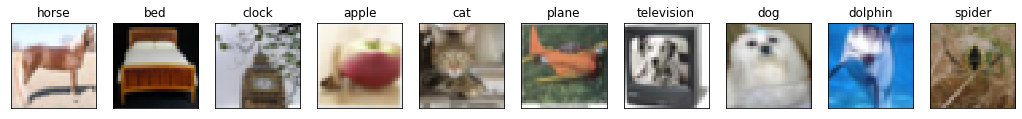

In [52]:
import matplotlib.pyplot as plt

def no_axis_show(img, title='', cmap=None):
  # imshow, and set the interpolation mode to be "nearest"。
  fig = plt.imshow(img, interpolation='nearest', cmap=cmap)
  # do not show the axes in the images.
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)
  plt.title(title)

titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'real_or_drawing/train_data/{i}/{500*i}.bmp'), title=titles[i])

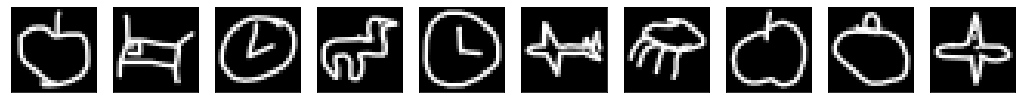

In [53]:
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'real_or_drawing/test_data/0/' + str(i).rjust(5, '0') + '.bmp'))

# Special Domain Knowledge

When we graffiti, we usually draw the outline only, therefore we can perform edge detection processing on the source data to make it more similar to the target data.


## Canny Edge Detection
The implementation of Canny Edge Detection is as follow.
The algorithm will not be describe thoroughly here.  If you are interested, please refer to the wiki or [here](https://medium.com/@pomelyu5199/canny-edge-detector-%E5%AF%A6%E4%BD%9C-opencv-f7d1a0a57d19).

We only need two parameters to implement Canny Edge Detection with CV2:  `low_threshold` and `high_threshold`.

```cv2.Canny(image, low_threshold, high_threshold)```

Simply put, when the edge value exceeds the high_threshold, we determine it as an edge. If the edge value is only above low_threshold, we will then determine whether it is an edge or not.

Let's implement it on the source data.

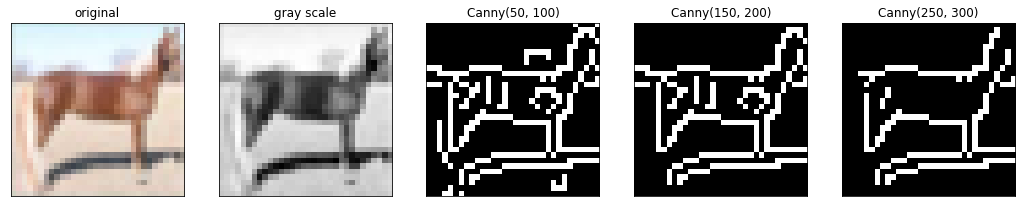

In [54]:
import cv2
import matplotlib.pyplot as plt
titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))

original_img = plt.imread(f'real_or_drawing/train_data/0/0.bmp')
plt.subplot(1, 5, 1)
no_axis_show(original_img, title='original')

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, title='gray scale', cmap='gray')

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, title='gray scale', cmap='gray')

canny_50100 = cv2.Canny(gray_img, 50, 100)
plt.subplot(1, 5, 3)
no_axis_show(canny_50100, title='Canny(50, 100)', cmap='gray')

canny_150200 = cv2.Canny(gray_img, 150, 200)
plt.subplot(1, 5, 4)
no_axis_show(canny_150200, title='Canny(150, 200)', cmap='gray')

canny_250300 = cv2.Canny(gray_img, 250, 300)
plt.subplot(1, 5, 5)
no_axis_show(canny_250300, title='Canny(250, 300)', cmap='gray')
  

# Data Process
 
 
The data is suitible for `torchvision.ImageFolder`. You can create a dataset with `torchvision.ImageFolder`. Details for image augmentation please refer to the comments in the following codes.

In [55]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
 
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
 
source_transform = transforms.Compose([
    # Turn RGB to grayscale. (Bacause Canny do not support RGB images.)
    transforms.Grayscale(),
    # cv2 do not support skimage.Image, so we transform it to np.array, 
    # and then adopt cv2.Canny algorithm.
    transforms.Lambda(lambda x: cv2.Canny(np.array(x), 170, 300)),
    # Transform np.array back to the skimage.Image.
    transforms.ToPILImage(),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero 
    # if there's empty pixel after rotation.
    transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])
target_transform = transforms.Compose([
    # Turn RGB to grayscale.
    transforms.Grayscale(),
    # Resize: size of source data is 32x32, thus we need to 
    #  enlarge the size of target data from 28x28 to 32x32。
    transforms.Resize((32, 32)),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero 
    # if there's empty pixel after rotation.
    transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])
 
source_dataset = ImageFolder('real_or_drawing/train_data', transform=source_transform)
target_dataset = ImageFolder('real_or_drawing/test_data', transform=target_transform)
 
source_dataloader = DataLoader(source_dataset, batch_size=32, shuffle=True)
target_dataloader = DataLoader(target_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(target_dataset, batch_size=128, shuffle=False)

# Model

Feature Extractor: Classic VGG-like architecture

Label Predictor / Domain Classifier: Linear models.

In [56]:
class FeatureExtractor(nn.Module):

    def __init__(self):
        super(FeatureExtractor, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
    def forward(self, x):
        x = self.conv(x).squeeze()
        return x

class LabelPredictor(nn.Module):

    def __init__(self):
        super(LabelPredictor, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, 10),
        )

    def forward(self, h):
        c = self.layer(h)
        return c

class DomainClassifier(nn.Module):

    def __init__(self):
        super(DomainClassifier, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 1),
        )

    def forward(self, h):
        y = self.layer(h)
        return y

# Pre-processing

Here we use Adam as our optimizor.

In [57]:
feature_extractor = FeatureExtractor().cuda()
label_predictor = LabelPredictor().cuda()
domain_classifier = DomainClassifier().cuda()

class_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.BCEWithLogitsLoss() #BCEloss 二分类交叉熵

optimizer_F = optim.Adam(feature_extractor.parameters())
optimizer_C = optim.Adam(label_predictor.parameters())
optimizer_D = optim.Adam(domain_classifier.parameters())

# Start Training


## DaNN Implementation

In the original paper, Gradient Reversal Layer is used.
Feature Extractor, Label Predictor, and Domain Classifier are all trained at the same time. In this code, we train Domain Classifier first, and then train our Feature Extractor (same concept as Generator and Discriminator training process in GAN).

## Reminder
* Lambda, which controls the domain adversarial loss, is adaptive in the original paper. You can refer to [the original work](https://arxiv.org/pdf/1505.07818.pdf) . Here lambda is set to 0.1.
* We do not have the label to target data, you can only evaluate your model by uploading your result to kaggle.:)

In [58]:
def train_epoch(source_dataloader, target_dataloader, lamb):
    '''
      Args:
        source_dataloader: source data的dataloader
        target_dataloader: target data的dataloader
        lamb: control the balance of domain adaptatoin and classification.
    '''

    # D loss: Domain Classifier的loss
    # F loss: Feature Extrator & Label Predictor的loss
    running_D_loss, running_F_loss = 0.0, 0.0
    total_hit, total_num = 0.0, 0.0

    for i, ((source_data, source_label), (target_data, _)) in enumerate(zip(source_dataloader, target_dataloader)):

        source_data = source_data.cuda()
        source_label = source_label.cuda()
        target_data = target_data.cuda()
        
        # Mixed the source data and target data, or it'll mislead the running params
        #   of batch_norm. (runnning mean/var of soucre and target data are different.)
        mixed_data = torch.cat([source_data, target_data], dim=0)
        domain_label = torch.zeros([source_data.shape[0] + target_data.shape[0], 1]).cuda()
        # set domain label of source data to be 1.
        domain_label[:source_data.shape[0]] = 1

        # Step 1 : train domain classifier
        feature = feature_extractor(mixed_data)
        # We don't need to train feature extractor in step 1.
        # *Thus we detach the feature neuron to avoid backpropgation.
        domain_logits = domain_classifier(feature.detach())
        loss = domain_criterion(domain_logits, domain_label)
        running_D_loss+= loss.item()
        loss.backward()
        optimizer_D.step()

        # Step 2 : train feature extractor and label classifier
        class_logits = label_predictor(feature[:source_data.shape[0]])
        domain_logits = domain_classifier(feature)
        # loss = cross entropy of classification - lamb * domain binary cross entropy.
        #  The reason why using subtraction is similar to generator loss in disciminator of GAN
        loss = class_criterion(class_logits, source_label) - lamb * domain_criterion(domain_logits, domain_label)
        running_F_loss+= loss.item()
        loss.backward()
        optimizer_F.step()
        optimizer_C.step()

        optimizer_D.zero_grad()
        optimizer_F.zero_grad()
        optimizer_C.zero_grad()

        total_hit += torch.sum(torch.argmax(class_logits, dim=1) == source_label).item()
        total_num += source_data.shape[0]
        print(i, end='\r')

    return running_D_loss / (i+1), running_F_loss / (i+1), total_hit / total_num

# train 200 epochs
for epoch in range(800):
    #lambda gradually change from 0.1 to 0.7
    t_lamb=1.2/(1+np.exp(-10*epoch/800))-0.5
    
    train_D_loss, train_F_loss, train_acc = train_epoch(source_dataloader, target_dataloader, lamb=t_lamb)

    torch.save(feature_extractor.state_dict(), f'extractor_model.bin')
    torch.save(label_predictor.state_dict(), f'predictor_model.bin')

    print('epoch {:>3d}: train D loss: {:6.4f}, train F loss: {:6.4f}, acc {:6.4f} lambda {:6.4f}'.format(epoch, train_D_loss, train_F_loss, train_acc,t_lamb))


epoch   0: train D loss: 0.7047, train F loss: 1.9101, acc 0.2636 lambda 0.1000
epoch   1: train D loss: 0.5969, train F loss: 1.5772, acc 0.4092 lambda 0.1037
epoch   2: train D loss: 0.5703, train F loss: 1.4518, acc 0.4648 lambda 0.1075
epoch   3: train D loss: 0.5475, train F loss: 1.3612, acc 0.5046 lambda 0.1112
epoch   4: train D loss: 0.5400, train F loss: 1.3129, acc 0.5182 lambda 0.1150
epoch   5: train D loss: 0.5446, train F loss: 1.2584, acc 0.5386 lambda 0.1187
epoch   6: train D loss: 0.5479, train F loss: 1.2186, acc 0.5572 lambda 0.1225
epoch   7: train D loss: 0.5487, train F loss: 1.1648, acc 0.5654 lambda 0.1262
epoch   8: train D loss: 0.5663, train F loss: 1.1258, acc 0.5828 lambda 0.1300
epoch   9: train D loss: 0.5634, train F loss: 1.0890, acc 0.5962 lambda 0.1337
epoch  10: train D loss: 0.5502, train F loss: 1.0720, acc 0.5956 lambda 0.1375
epoch  11: train D loss: 0.5832, train F loss: 1.0159, acc 0.6226 lambda 0.1412
epoch  12: train D loss: 0.5428, train F

epoch 102: train D loss: 0.6118, train F loss: -0.1473, acc 0.9620 lambda 0.4379
epoch 103: train D loss: 0.6081, train F loss: -0.1648, acc 0.9686 lambda 0.4405
epoch 104: train D loss: 0.6139, train F loss: -0.1540, acc 0.9626 lambda 0.4430
epoch 105: train D loss: 0.6156, train F loss: -0.1581, acc 0.9614 lambda 0.4455
epoch 106: train D loss: 0.6116, train F loss: -0.1538, acc 0.9652 lambda 0.4480
epoch 107: train D loss: 0.6164, train F loss: -0.1478, acc 0.9606 lambda 0.4505
epoch 108: train D loss: 0.6199, train F loss: -0.1575, acc 0.9620 lambda 0.4530
epoch 109: train D loss: 0.6127, train F loss: -0.1620, acc 0.9650 lambda 0.4554
epoch 110: train D loss: 0.6105, train F loss: -0.1801, acc 0.9710 lambda 0.4578
epoch 111: train D loss: 0.6073, train F loss: -0.1689, acc 0.9656 lambda 0.4602
epoch 112: train D loss: 0.6121, train F loss: -0.1793, acc 0.9698 lambda 0.4626
epoch 113: train D loss: 0.6157, train F loss: -0.1723, acc 0.9668 lambda 0.4650
epoch 114: train D loss: 0.6

epoch 204: train D loss: 0.6357, train F loss: -0.3080, acc 0.9766 lambda 0.6131
epoch 205: train D loss: 0.6423, train F loss: -0.3158, acc 0.9774 lambda 0.6141
epoch 206: train D loss: 0.6373, train F loss: -0.3195, acc 0.9800 lambda 0.6151
epoch 207: train D loss: 0.6395, train F loss: -0.3147, acc 0.9794 lambda 0.6161
epoch 208: train D loss: 0.6392, train F loss: -0.3171, acc 0.9796 lambda 0.6170
epoch 209: train D loss: 0.6397, train F loss: -0.3185, acc 0.9784 lambda 0.6180
epoch 210: train D loss: 0.6382, train F loss: -0.3154, acc 0.9758 lambda 0.6189
epoch 211: train D loss: 0.6376, train F loss: -0.3090, acc 0.9768 lambda 0.6199
epoch 212: train D loss: 0.6438, train F loss: -0.3226, acc 0.9806 lambda 0.6208
epoch 213: train D loss: 0.6430, train F loss: -0.3159, acc 0.9768 lambda 0.6217
epoch 214: train D loss: 0.6427, train F loss: -0.3208, acc 0.9770 lambda 0.6226
epoch 215: train D loss: 0.6426, train F loss: -0.3279, acc 0.9792 lambda 0.6235
epoch 216: train D loss: 0.6

epoch 306: train D loss: 0.6504, train F loss: -0.3835, acc 0.9844 lambda 0.6744
epoch 307: train D loss: 0.6564, train F loss: -0.3677, acc 0.9806 lambda 0.6747
epoch 308: train D loss: 0.6537, train F loss: -0.3785, acc 0.9824 lambda 0.6750
epoch 309: train D loss: 0.6492, train F loss: -0.3751, acc 0.9822 lambda 0.6753
epoch 310: train D loss: 0.6488, train F loss: -0.3796, acc 0.9824 lambda 0.6756
epoch 311: train D loss: 0.6473, train F loss: -0.3738, acc 0.9816 lambda 0.6759
epoch 312: train D loss: 0.6481, train F loss: -0.3754, acc 0.9834 lambda 0.6762
epoch 313: train D loss: 0.6488, train F loss: -0.3759, acc 0.9816 lambda 0.6765
epoch 314: train D loss: 0.6489, train F loss: -0.3835, acc 0.9850 lambda 0.6768
epoch 315: train D loss: 0.6552, train F loss: -0.3753, acc 0.9812 lambda 0.6771
epoch 316: train D loss: 0.6485, train F loss: -0.3705, acc 0.9826 lambda 0.6773
epoch 317: train D loss: 0.6469, train F loss: -0.3794, acc 0.9836 lambda 0.6776
epoch 318: train D loss: 0.6

epoch 408: train D loss: 0.6553, train F loss: -0.3891, acc 0.9838 lambda 0.6927
epoch 409: train D loss: 0.6570, train F loss: -0.3949, acc 0.9812 lambda 0.6928
epoch 410: train D loss: 0.6576, train F loss: -0.4057, acc 0.9852 lambda 0.6929
epoch 411: train D loss: 0.6512, train F loss: -0.4103, acc 0.9884 lambda 0.6930
epoch 412: train D loss: 0.6529, train F loss: -0.4022, acc 0.9864 lambda 0.6931
epoch 413: train D loss: 0.6575, train F loss: -0.3883, acc 0.9820 lambda 0.6932
epoch 414: train D loss: 0.6499, train F loss: -0.3895, acc 0.9824 lambda 0.6933
epoch 415: train D loss: 0.6533, train F loss: -0.3959, acc 0.9862 lambda 0.6933
epoch 416: train D loss: 0.6545, train F loss: -0.4002, acc 0.9848 lambda 0.6934
epoch 417: train D loss: 0.6491, train F loss: -0.3993, acc 0.9864 lambda 0.6935
epoch 418: train D loss: 0.6559, train F loss: -0.3979, acc 0.9824 lambda 0.6936
epoch 419: train D loss: 0.6498, train F loss: -0.3936, acc 0.9832 lambda 0.6937
epoch 420: train D loss: 0.6

epoch 510: train D loss: 0.6574, train F loss: -0.4131, acc 0.9870 lambda 0.6980
epoch 511: train D loss: 0.6588, train F loss: -0.4091, acc 0.9872 lambda 0.6980
epoch 512: train D loss: 0.6582, train F loss: -0.4189, acc 0.9886 lambda 0.6980
epoch 513: train D loss: 0.6627, train F loss: -0.4162, acc 0.9870 lambda 0.6980
epoch 514: train D loss: 0.6573, train F loss: -0.4007, acc 0.9842 lambda 0.6981
epoch 515: train D loss: 0.6632, train F loss: -0.4265, acc 0.9886 lambda 0.6981
epoch 516: train D loss: 0.6588, train F loss: -0.4024, acc 0.9856 lambda 0.6981
epoch 517: train D loss: 0.6551, train F loss: -0.4160, acc 0.9878 lambda 0.6981
epoch 518: train D loss: 0.6551, train F loss: -0.4069, acc 0.9878 lambda 0.6982
epoch 519: train D loss: 0.6513, train F loss: -0.4121, acc 0.9884 lambda 0.6982
epoch 520: train D loss: 0.6576, train F loss: -0.4080, acc 0.9860 lambda 0.6982
epoch 521: train D loss: 0.6591, train F loss: -0.4079, acc 0.9846 lambda 0.6982
epoch 522: train D loss: 0.6

epoch 612: train D loss: 0.6554, train F loss: -0.4154, acc 0.9906 lambda 0.6994
epoch 613: train D loss: 0.6553, train F loss: -0.4113, acc 0.9870 lambda 0.6994
epoch 614: train D loss: 0.6584, train F loss: -0.4235, acc 0.9908 lambda 0.6994
epoch 615: train D loss: 0.6564, train F loss: -0.4169, acc 0.9876 lambda 0.6995
epoch 616: train D loss: 0.6529, train F loss: -0.4105, acc 0.9882 lambda 0.6995
epoch 617: train D loss: 0.6614, train F loss: -0.4260, acc 0.9910 lambda 0.6995
epoch 618: train D loss: 0.6576, train F loss: -0.4105, acc 0.9860 lambda 0.6995
epoch 619: train D loss: 0.6565, train F loss: -0.4216, acc 0.9902 lambda 0.6995
epoch 620: train D loss: 0.6579, train F loss: -0.4128, acc 0.9860 lambda 0.6995
epoch 621: train D loss: 0.6623, train F loss: -0.4089, acc 0.9854 lambda 0.6995
epoch 622: train D loss: 0.6552, train F loss: -0.4140, acc 0.9886 lambda 0.6995
epoch 623: train D loss: 0.6553, train F loss: -0.4048, acc 0.9858 lambda 0.6995
epoch 624: train D loss: 0.6

epoch 714: train D loss: 0.6616, train F loss: -0.4133, acc 0.9856 lambda 0.6998
epoch 715: train D loss: 0.6538, train F loss: -0.3495, acc 0.9788 lambda 0.6998
epoch 716: train D loss: 0.6544, train F loss: -0.4034, acc 0.9832 lambda 0.6998
epoch 717: train D loss: 0.6552, train F loss: -0.4146, acc 0.9894 lambda 0.6998
epoch 718: train D loss: 0.6502, train F loss: -0.4111, acc 0.9880 lambda 0.6998
epoch 719: train D loss: 0.6504, train F loss: -0.4055, acc 0.9878 lambda 0.6999
epoch 720: train D loss: 0.6571, train F loss: -0.4140, acc 0.9888 lambda 0.6999
epoch 721: train D loss: 0.6574, train F loss: -0.4126, acc 0.9886 lambda 0.6999
epoch 722: train D loss: 0.6532, train F loss: -0.4165, acc 0.9902 lambda 0.6999
epoch 723: train D loss: 0.6547, train F loss: -0.4171, acc 0.9896 lambda 0.6999
epoch 724: train D loss: 0.6589, train F loss: -0.4197, acc 0.9886 lambda 0.6999
epoch 725: train D loss: 0.6562, train F loss: -0.4170, acc 0.9890 lambda 0.6999
epoch 726: train D loss: 0.6

# Inference

We use pandas to generate our csv file.

BTW, the performance of the model trained for 200 epoches might be unstable. You can train for more epoches for a more stable performance.

In [59]:
result = []
label_predictor.eval()
feature_extractor.eval()
for i, (test_data, _) in enumerate(test_dataloader):
    test_data = test_data.cuda()

    class_logits = label_predictor(feature_extractor(test_data))

    x = torch.argmax(class_logits, dim=1).cpu().detach().numpy()
    result.append(x)

import pandas as pd
result = np.concatenate(result)

# Generate your submission
df = pd.DataFrame({'id': np.arange(0,len(result)), 'label': result})
df.to_csv('DaNN_submission.csv',index=False)

# Training Statistics

- Number of parameters:
  - Feature Extractor: 2, 142, 336
  - Label Predictor: 530, 442
  - Domain Classifier: 1, 055, 233

- Simple
 - Training time on colab: ~ 1 hr
- Medium
 - Training time on colab: 2 ~ 4 hr
- Strong
 - Training time on colab: 5 ~ 6 hrs
- Boss
 - **Unmeasurable**

# Learning Curve (Strong Baseline)
* This method is slightly different from colab.

![Loss Curve](https://i.imgur.com/vIujQyo.png)

# Accuracy Curve (Strong Baseline)
* Note that you cannot access testing accuracy. But this plot tells you that even though the model overfits the training data, the testing accuracy is still improving, and that's why you need to train more epochs.

![Acc Curve](https://i.imgur.com/4W1otXG.png)



# Q&A

If there are any problem related to Domain Adaptation, please email to b05902127@ntu.edu.tw / ntu-ml-2020spring-ta@googlegroups.com。

The Q&A section might be updated to here if I have time.
